# 1. Importing Libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import string
import re

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\rk\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\rk\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\rk\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\rk\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

# 2. Data Loading

In [2]:
data = pd.read_csv('fake_reviews_dataset.csv')
data['text_'] = data['text_'].astype(str)

# 3. Data Exploration

In [3]:
data.head()

,category,rating,label,text_
0,Home_and_Kitchen_5,5.0,CG,"Love this! Well made, sturdy, and very comfor..."
1,Home_and_Kitchen_5,5.0,CG,"love it, a great upgrade from the original. I..."
2,Home_and_Kitchen_5,5.0,CG,This pillow saved my back. I love the look and...
3,Home_and_Kitchen_5,1.0,CG,"Missing information on how to use it, but it i..."
4,Home_and_Kitchen_5,5.0,CG,Very nice set. Good quality. We have had the s...


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40432 entries, 0 to 40431
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   category  40432 non-null  object 
 1   rating    40432 non-null  float64
 2   label     40432 non-null  object 
 3   text_     40432 non-null  object 
dtypes: float64(1), object(3)
memory usage: 1.2+ MB


In [5]:
data.groupby('category')['rating'].mean()

category
Books_5                         4.254691
Clothing_Shoes_and_Jewelry_5    4.172817
Electronics_5                   4.167503
Home_and_Kitchen_5              4.246795
Kindle_Store_5                  4.373996
Movies_and_TV_5                 4.148272
Pet_Supplies_5                  4.209685
Sports_and_Outdoors_5           4.316776
Tools_and_Home_Improvement_5    4.306117
Toys_and_Games_5                4.343437
Name: rating, dtype: float64

In [6]:
data['rating'].value_counts()

rating
5.0    24559
4.0     7965
3.0     3786
1.0     2155
2.0     1967
Name: count, dtype: int64

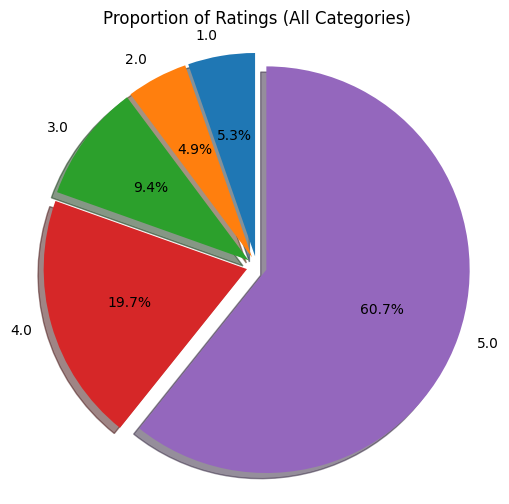

In [7]:
rating_counts = data['rating'].value_counts().sort_index()

explode = [0.05] * len(rating_counts) 

plt.figure(figsize=(6, 6))
plt.pie(
    rating_counts,
    labels=rating_counts.index,
    autopct='%1.1f%%',
    startangle=90,
    explode=explode,
    shadow=True 
)
plt.title('Proportion of Ratings (All Categories)')
plt.axis('equal')
plt.show()

# 4. Data Preprocessing

In [ ]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

In [9]:
def preprocess(text):
    text = text.lower()
    text = re.sub(r'<.*?>', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    
    tokens = word_tokenize(text)

    cleaned = []
    for word in tokens:
        word = word.translate(str.maketrans('', '', string.punctuation))
        if word.isalpha() and word not in stop_words:
            lemma = lemmatizer.lemmatize(word)
            cleaned.append(lemma)

    return ' '.join(cleaned)

In [ ]:
data['clean_text'] = data['text_'].apply(preprocess)

In [11]:
data.head()

,category,rating,label,text_,clean_text
0,Home_and_Kitchen_5,5.0,CG,"Love this! Well made, sturdy, and very comfor...",love well made sturdy comfortable love pretty
1,Home_and_Kitchen_5,5.0,CG,"love it, a great upgrade from the original. I...",love great upgrade original mine couple year
2,Home_and_Kitchen_5,5.0,CG,This pillow saved my back. I love the look and...,pillow saved back love look feel pillow
3,Home_and_Kitchen_5,1.0,CG,"Missing information on how to use it, but it i...",missing information use great product price
4,Home_and_Kitchen_5,5.0,CG,Very nice set. Good quality. We have had the s...,nice set good quality set two month


In [12]:
data = data.drop(columns=['text_'])